# Scorecard Development: A Python Approach

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#home = '/home/admin/ds_training/projects/scorecard'
home = '/Users/liuqing/OneDrive/training/scorecard/lending_club'

Lending Club是全球最大的撮合借款人和投资人的线上金融平台，它利用互联网模式建立了一种比传统银行系统更有效率的、能够在借款人和投资人之间自由配置资本的机制。

这里下载了2018年第1季度-2018年第4季度的数据，构建评分卡模型，数据在data文件夹下

原始数据集的下载地址为：https://www.lendingclub.com/info/download-data.action

主要包括以下几步
* EDA
    * 好坏定义说明
    * 数据处理与清洗
    * 变量初筛
    * 数据的统计与分析
* 变量分箱与WOE转换
* 特征选择
* 模型构建与评估
* 评分刻度与实施
* 评分卡评估与监控

# EDA

### 读入数据

In [4]:
names = ['LoanStats_2018Q1','LoanStats_2018Q2','LoanStats_2018Q3','LoanStats_2018Q4']
data_list=[]
for name in names:
    data=pd.read_csv(home + '/data/' + name + '.csv', skiprows=[0])
    data.drop(data.tail(2).index,inplace=True) # drop last 2 rows
    data_list.append(data)
loan = pd.concat(data_list,ignore_index=True)
loan.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  NaN        NaN     5000.0       5000.0           5000.0   36 months   
1  NaN        NaN    15000.0      15000.0          15000.0   36 months   
2  NaN        NaN    11200.0      11200.0          11200.0   60 months   
3  NaN        NaN    25000.0      25000.0          25000.0   60 months   
4  NaN        NaN     3000.0       3000.0           3000.0   36 months   

  int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0   20.39%       186.82     D        D4  ...                            NaN   
1    9.92%       483.45     B        B2  ...                            NaN   
2   30.79%       367.82     G        G1  ...                            NaN   
3   21.85%       688.35     D        D5  ...                            NaN   
4    7.34%        93.10     A        A4  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount  settlement_percentage  settlement_term  
0               NaN                    NaN              NaN  
1               NaN                    NaN              NaN  
2               NaN                    NaN              NaN  
3               NaN                    NaN              NaN  
4               NaN                    NaN              NaN  

[5 rows x 145 columns]

In [5]:
# 为了后期数据探索的方便，我们还需读入数据字典
data_dict1 = pd.read_excel(home + '/data/LCDataDictionary.xlsx', sheet_name='LoanStats')\
               .set_index("LoanStatNew")\
               .dropna(how='any')
data_dict2 = pd.read_excel(home + '/data/LCDataDictionary.xlsx', sheet_name='browseNotes')\
               .set_index("BrowseNotesFile")\
               .dropna(how='any')

In [6]:
data_dict = pd.concat([data_dict1, data_dict2])
data_dict.index = data_dict.index.str.strip()
data_dict = data_dict['Description'].to_dict()

### 数据类型转换: 处理带有百分号的数据

In [7]:
# %%
loan['revol_util'] = loan['revol_util'].str.rstrip('%').astype('float')
loan['int_rate'] = loan['int_rate'].str.rstrip('%').astype('float')
loan['term'] = loan['term'].str.rstrip('months').astype('float')

### 好坏定义说明
要开发一个申请的评分卡，最重要的就是先定义好坏，确定建模的目标，也就是编码y为0和1。

查看本次数据的y值分布如下：

In [8]:
# %%
mapping = {'Current':'还款中',
           'Fully Paid':'全额结清',
           'Charged Off':'坏账',
           'In Grace Period':'宽限期',
           'Late (31-120 days)':'逾期（31-120天）',
           'Late (16-30 days)':'逾期（16-30天）',
           'Default':'违约'}
y_dist = loan['loan_status'].apply(lambda x:mapping[x])\
                            .value_counts()\
                            .to_frame(name='计数')
y_dist['百分比'] = (y_dist['计数'] / loan.shape[0]) * 100

In [9]:
y_dist

计数        百分比
还款中          427181  86.257022
全额结清          47444   9.579963
坏账             8867   1.790438
逾期（31-120天）    7221   1.458075
宽限期            2919   0.589409
逾期（16-30天）     1603   0.323680
违约                7   0.001413

这里我们定义逾期30天以上的客户为坏客户，未发生逾期的为好客户。

处于逾期（16-30天）和宽限期的客户，介于好坏之间，暂时不纳入模型。

Bad: Late (31-120 days) , Charged Off(坏账), 'Default':'违约'
Good: Current(还款中), Fully Paid(结清)

In [10]:
# %%
def derive_y(x):
    if x in ['Current', 'Fully Paid']:
        return 0
    elif x in ['Late (31-120 days)', 'Default', 'Charged Off']:
        return 1
    else:
        np.nan
loan['y'] = loan['loan_status'].apply(derive_y)
loan['y'].value_counts(dropna=False) / loan.shape[0]
loan.drop(columns=['loan_status'], inplace=True)
loan = loan[loan['y'].notnull()]

In [11]:
loan['y'].value_counts() / loan.shape[0]

0.0    0.967201
1.0    0.032799
Name: y, dtype: float64

Y字段bad占比为3%，属于不平衡样本。后期可尝试做不平衡样本处理。

### 变量初步筛选
在进一步分析之前，需要将一些冗余变量筛除
这里面包括：
* 时间变量
* 缺失值100%缺失对变量
* 所有值都相同都变量
* 对模型没有意义的变量：如ID，Title等等分类过多的变量
* 100%的值都相同的变量

In [12]:
temp = loan.isnull().sum()
del_by_full_miss = temp[temp == loan.shape[0]].index.tolist()

In [13]:
temp = loan.select_dtypes('object').nunique()\
           .sort_values(ascending=False)
del_by_count = temp[(temp > 500) | (temp == 1)].index.tolist()

In [14]:
del_by_date = ['next_pymnt_d', 'last_credit_pull_d', 'last_pymnt_d',
                'issue_d', 'last_credit_pull_d', 'debt_settlement_flag_date',
                'settlement_date', 'payment_plan_start_date', 'earliest_cr_line']

In [15]:
del_by_variance = []
for col in loan:
    temp = loan[col].value_counts().max() / loan[col].notnull().sum()
    if temp == 1:
        del_by_variance.append(col)

In [16]:
loan.drop(columns=del_by_count + del_by_full_miss + del_by_date + del_by_variance, inplace=True)

In [17]:
loan.shape

(490720, 125)

### EDA和数据描述
原始数据经过初筛之后共有125个字段，字段的数据字典见：LCDataDictionary.xlsx。

EDA主要包括对以下部分的探索：
* 缺失值统计与处理
* 每个候选变量的统计特征和分布
* 变量之间的线性相关

##### 缺失值处理

In [18]:
def missing_values_table(df):
    """
    check missing data
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns['dtype'] = df.dtypes

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
    "There are " + str(mis_val_table_ren_columns.shape[0]) +
    " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [19]:
miss_stat = missing_values_table(loan)
miss_stat['label'] = miss_stat.index.map(lambda x:data_dict.get(x))
miss_stat.set_index('label', append=True, inplace=True)
miss_stat.head()

Your selected dataframe has 125 columns.
There are 46 columns that have missing values.


Missing Values  \
                                           label                                                                
orig_projected_additional_accrued_interest The original projected additional interest amou...          490438   
hardship_end_date                          The end date of the hardship plan period                    490391   
hardship_loan_status                       Loan Status as of the hardship plan start date              490391   
hardship_reason                            Describes the reason the hardship plan was offered          490391   
hardship_status                            Describes if the hardship plan is active, pendi...          490391   

                                                                                               % of Total Values  \
                                           label                                                                   
orig_projected_additional_accrued_interest The original projected additional interest amou...               99.9   
hardship_end_date                          The end date of the hardship plan period                         99.9   
hardship_loan_status                       Loan Status as of the hardship plan start date                   99.9   
hardship_reason                            Describes the reason the hardship plan was offered               99.9   
hardship_status                            Describes if the hardship plan is active, pendi...               99.9   

                                                                                                 dtype  
                                           label                                                        
orig_projected_additional_accrued_interest The original projected additional interest amou...  float64  
hardship_end_date                          The end date of the hardship plan period             object  
hardship_loan_status                       Loan Status as of the hardship plan start date       object  
hardship_reason                            Describes the reason the hardship plan was offered   object  
hardship_status                            Describes if the hardship plan is active, pendi...   object

这里直接对缺失值大于95.5%的变量进行删除。

In [20]:
# %%
miss_delete = miss_stat[miss_stat['% of Total Values'] > 95.5].index.get_level_values(0)
loan = loan[[col for col in loan.columns if col not in miss_delete]]
print("deleted number of columns: {0}".format(len(miss_delete)))

deleted number of columns: 14


##### 统计候选特征的统计特征和分布
我们对连续变量和分类变量分别作出单变量统计

大多数统计量可以在pandas中计算得到，主要包括以下几类：
* 矩，如均值、众数和标准差
* 分位数，如第一、第三分位数
* 极端值，包括极大和极小值
* 频数，以及占比

对于连续变量，可使用下面函数进行统计

In [21]:
# %%
def num_describe(df, target):
    stat_num = df.groupby(target)\
                 .describe(percentiles=[0.01, 0.05,
                                            0.1, 0.25,
                                            0.5, 0.75,
                                            0.9, 0.95, 0.99
                            ]).stack(level=0)\
                              .swaplevel(0,1).sort_index()

    stat_num['nmiss'] = df.groupby(target).apply(lambda x:x.isnull().sum())\
                        .stack(level=0)\
                        .swaplevel(0,1).sort_index()
    stat_num['miss_percent'] = stat_num['nmiss'] / df.shape[0]

    stat_num['nzero'] = df.groupby(target).apply(lambda x:(x == 0).sum())\
                        .stack(level=0)\
                        .swaplevel(0,1).sort_index()
    stat_num['zero_percent'] = stat_num['nzero'] / df.shape[0]

    stat_num.rename(columns={
            "count":"计数",
            'mean':"平均值",
            'std':"标准差",
            'min':"最小值",
            "max":"最大值",
            'nmiss':"缺失值",
            "miss_percent":"缺失值占比",
            'nzero':"零值",
            "zero_percent":"零值占比"
    }, inplace=True)
    stat_num.index.names = ['feature', 'target']

    columns = ['计数', '缺失值', '缺失值占比', '零值', '零值占比', '平均值', '标准差', '最小值', '1%', '5%', '10%',
               '25%', '50%', '75%', '90%', '95%', '99%', '最大值']
    sort_columns = ['feature', 'target']
    ascending_columns = [True, True]

    return stat_num[columns]\
           .sort_values(by = sort_columns, ascending = ascending_columns)

In [25]:
df = loan.select_dtypes('float')
num_describe(df, 'y').head()

计数  缺失值     缺失值占比      零值      零值占比  \
feature              target                                              
acc_now_delinq       0.0     474625.0    0  0.000000  474606  0.967163   
                     1.0      16095.0    0  0.000000   16090  0.032789   
acc_open_past_24mths 0.0     474625.0    0  0.000000   24623  0.050177   
                     1.0      16095.0    0  0.000000     654  0.001333   
all_util             0.0     474504.0  121  0.000247    1432  0.002918   

                                   平均值        标准差  最小值   1%    5%   10%   25%  \
feature              target                                                     
acc_now_delinq       0.0      0.000040   0.006327  0.0  0.0   0.0   0.0   0.0   
                     1.0      0.000311   0.017623  0.0  0.0   0.0   0.0   0.0   
acc_open_past_24mths 0.0      4.401966   3.221366  0.0  0.0   0.0   1.0   2.0   
                     1.0      5.052066   3.489429  0.0  0.0   1.0   1.0   3.0   
all_util             0.0     54.016870  20.982368  0.0  5.0  18.0  26.0  40.0   

                              50%   75%   90%   95%    99%    最大值  
feature              target                                        
acc_now_delinq       0.0      0.0   0.0   0.0   0.0    0.0    1.0  
                     1.0      0.0   0.0   0.0   0.0    0.0    1.0  
acc_open_past_24mths 0.0      4.0   6.0   9.0  10.0   15.0   54.0  
                     1.0      4.0   7.0  10.0  12.0   16.0   36.0  
all_util             0.0     55.0  69.0  80.0  87.0  100.0  239.0

对于分类变量，可使用下面函数进行统计

In [23]:
# %%
def cat_describe(df, target, target_value=1):
    N = df.shape[0]
    y = df[target]
    result = []
    for col in df.drop(columns=target):
        s = df[col]
        stat = pd.crosstab(s.fillna('缺失值'), y, dropna=False)
        count_all = stat.sum(axis=1).astype(int)
        count_all_percent = (count_all / N).round(3)
        stat['计数'], stat['占比'] = count_all, count_all_percent
        if target_value in stat.columns.tolist():
            count_target = stat[target_value].astype(int)
            count_target_percent = (count_target / stat['计数']).round(3)

            stat['计数(target = {0})'.format(target_value)], stat['占比(target = {0})'.format(target_value)] = count_target, count_target_percent
            stat['feature'] = s.name
            stat.columns.name = None
            cat = stat.index
            cat.name = '类别'
            stat.set_index(['feature', cat], inplace=True)

            stat.sort_values("计数", ascending=False, inplace=True)

            stat = stat[['计数', '占比',
                        '计数(target = {0})'.format(target_value),
                        '占比(target = {0})'.format(target_value)]]
            result.append(stat)
    return pd.concat(result)

In [26]:
df = loan.select_dtypes('object')
df['y'] = loan['y']
cat_describe(df, 'y', target_value=1).head()

计数     占比  计数(target = 1)  占比(target = 1)
feature 类别                                               
grade   B   140367  0.286            3356           0.024
        A   134706  0.275            1176           0.009
        C   125378  0.255            5103           0.041
        D    67948  0.138            4392           0.065
        E    18576  0.038            1584           0.085

##### 变量之间的线性相关
对于连续变量，采用person相关系数计算其相关性
对于分类变量，采用卡方检验计算其相关性

In [27]:
# %%
plt.style.use('fivethirtyeight')
num_data = loan.select_dtypes(['float', 'float32'])
corr_matrix = num_data.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan

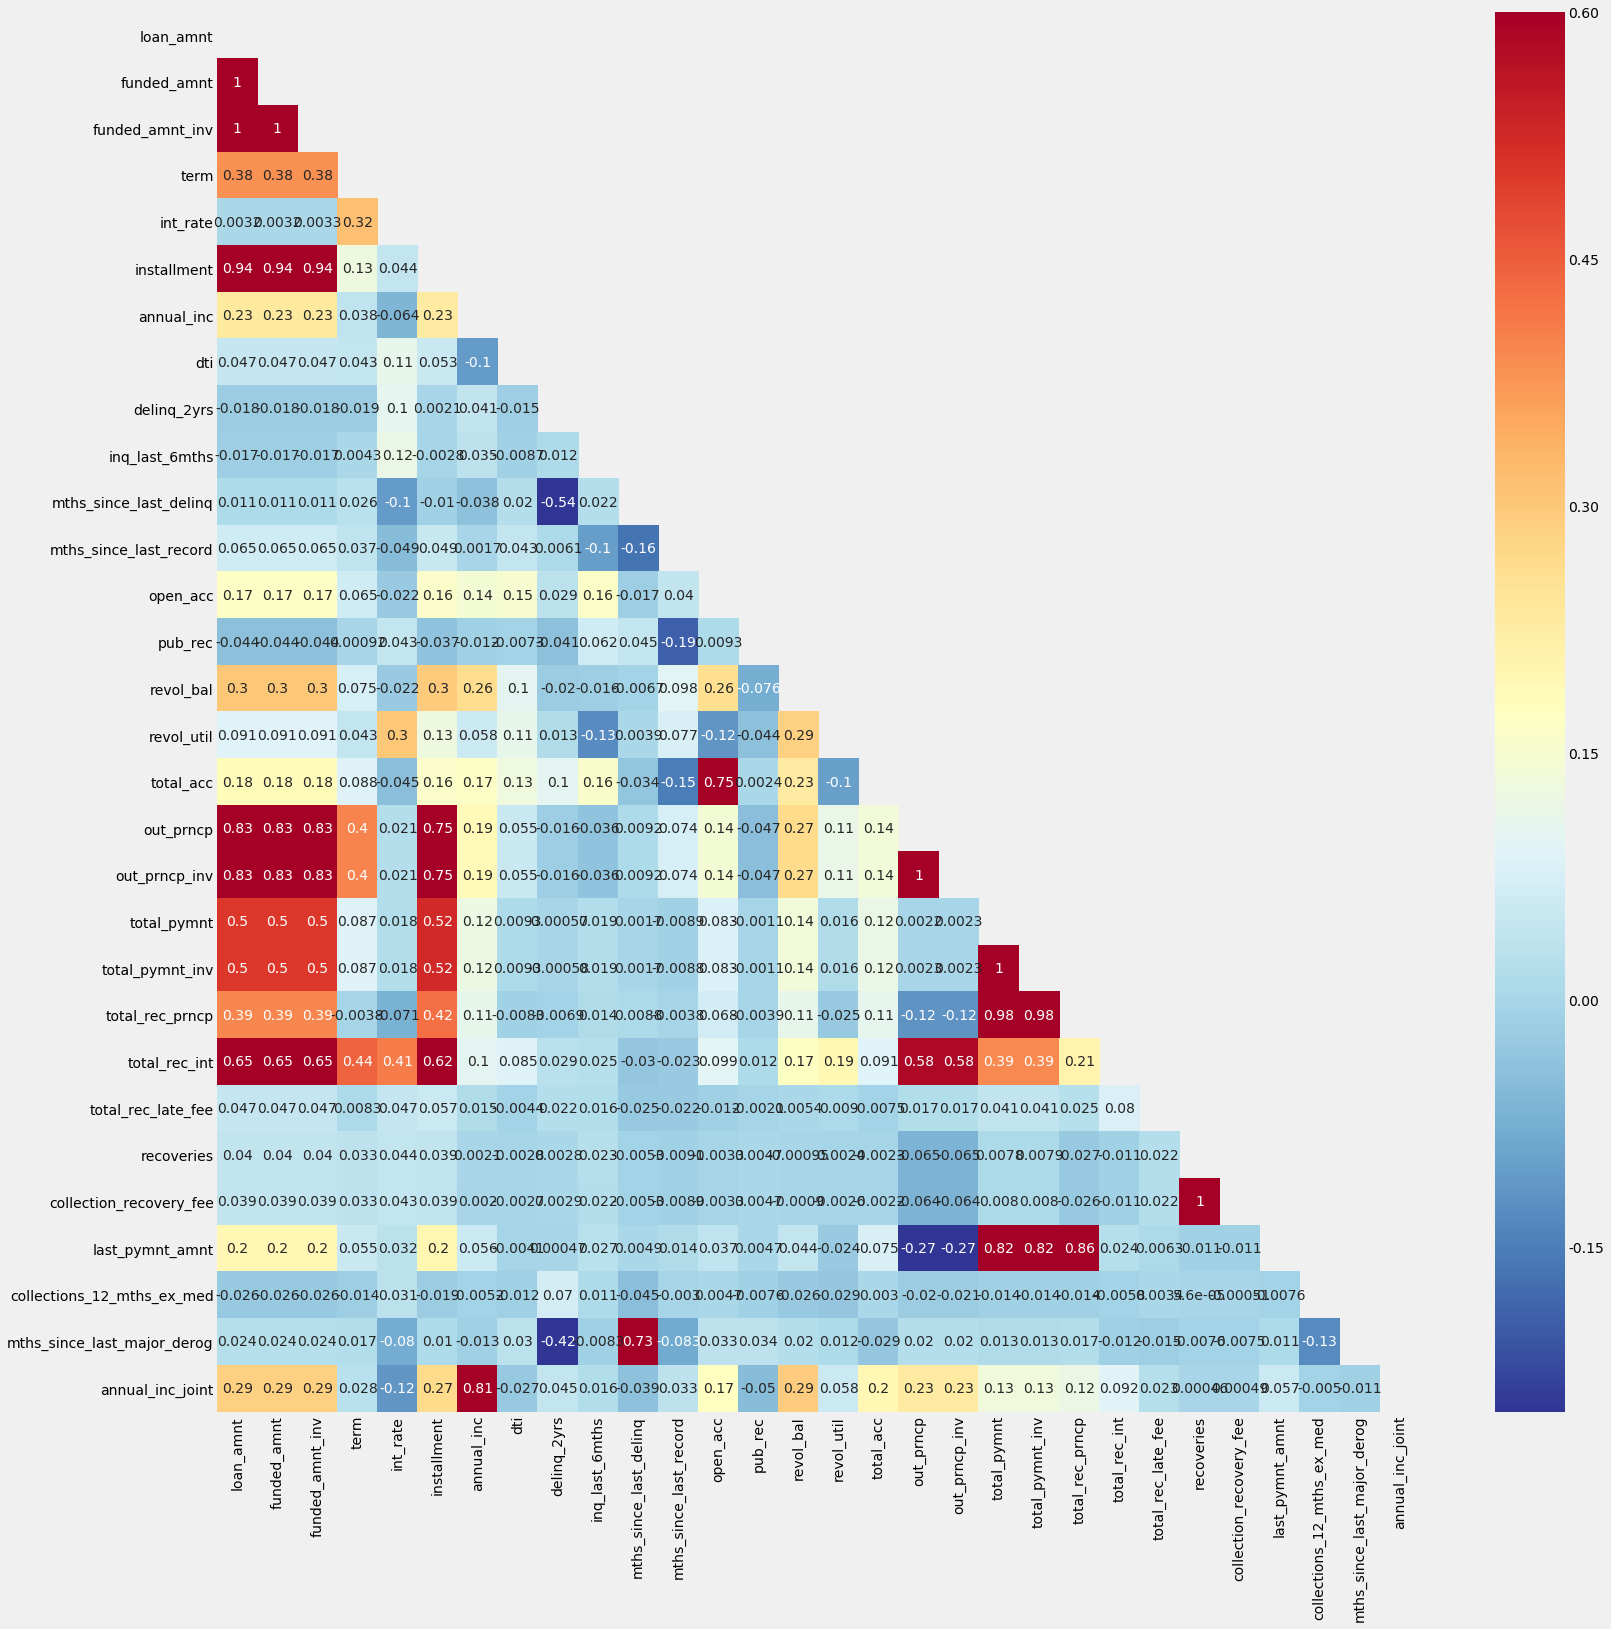

In [28]:
# Heatmap of correlations
plt.figure(figsize = (24, 24))
sns.heatmap(corr_matrix.iloc[:30, :30], mask=mask[:30, :30], cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)

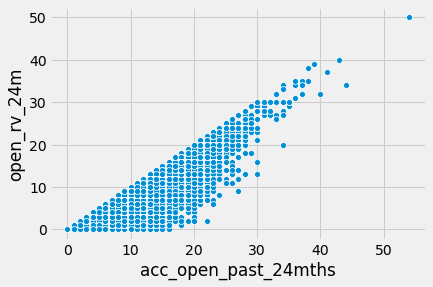

In [29]:
ax = sns.scatterplot(x="acc_open_past_24mths",
                     y="open_rv_24m",
                     data=loan)

可以看到有较多字段存在强线性相关

这里将相关系数>0.9的字段，选择删除

In [30]:
corr_select = corr_matrix.stack().to_frame(name='pearson').reset_index()\
              .query("level_0 != level_1")\
              .query("pearson > 0.9")\
              .sort_values(by='level_0')

In [31]:
loan.drop(columns=['collection_recovery_fee', 'funded_amnt',
                    'funded_amnt_inv',
                    'installment', 'num_rev_tl_bal_gt_0', 'num_sats',
                    'num_tl_30dpd', 'out_prncp_inv', 'tot_hi_cred_lim',
                    'total_bal_ex_mort', 'total_rec_prncp', 'total_pymnt_inv',
                    'total_il_high_credit_limit'], inplace=True)

In [32]:
loan.shape

(490720, 98)

计算分类变量的卡方值，采用卡方检验计算其相关性

In [33]:
from scipy import stats
chi2_table = {}
cat_data = loan.select_dtypes('object')

In [34]:
for i in range(cat_data.shape[1]):
    column_i = cat_data.iloc[::, i]
    for j in range(i+1, cat_data.shape[1]):
        column_j = cat_data.iloc[::, j]
        contigency = pd.crosstab(column_i, column_j)
        pvalue = stats.chi2_contingency(contigency.values)[1]
        chi2_table[column_i.name + '-' + column_j.name] = pvalue
chisq_select = pd.DataFrame([chi2_table], index=['pvalue'])\
                 .T.query('pvalue < 0.0001')\
                 .sort_values(by='pvalue')

In [35]:
chisq_select.head()

pvalue
addr_state-application_type         0.0
home_ownership-addr_state           0.0
home_ownership-application_type     0.0
home_ownership-purpose              0.0
home_ownership-title                0.0

# 变量分箱与WOE转换

### 分类变量降低基数 

当名义变量的类别数大于12个，降低基数就变得非常必要。

降低名义变量的基数有三个主要策略：

1. 将相同含义的变量合并。但是，由于没有考虑默认的状态变量和被合并类别之间的关联性，可能导致预测力降低
2. 出现频率小的类别被合并为一个新的类别，并给与一个合适的标识，如“Other”
3. 最后一种，也是绝大多数人偏爱的一种方法：合并变量的类别使某些预测力指标最大化。

这里重点介绍第三种方法：最优分群。
以下图为例：

![alt text](http://static.zybuluo.com/77qingliu/rifjbm9t9ubaitrw83pea7c5/image.png)

该算法的目的是生成较少数量的类别，该变量的某些预测力指标将得到优化。

进行最优分组的算法是基于决策树模型所用的方法。

在这种情况下，首先假设所有的类别都属于一个组，然后，找出最优化的二元分割方法。最优化分割标准可以用一下四个常用的预测力指标：

scorecardpy的作者实现了最优分群的函数，可以方便地直接调用

In [34]:
from scorecardpy import woebin
cat_data = loan.select_dtypes('object')
cat_data['y'] = loan['y']
cat_data.nunique().sort_values(ascending=False)
cat_combine_bin = woebin(cat_data, y="y", stop_limit=0.01)
cat_combine_bin['emp_length']

>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
addr_state
>>> Continue the binning process?
1: yes 
2: no 

Selection: 1
Binning on 490720 rows and 16 columns in 00:00:12


variable                                   bin   count  count_distr  \
0  emp_length                               missing   41521     0.084612   
1  emp_length                   10+ years%,%9 years  171560     0.349609   
2  emp_length                    6 years%,%< 1 year   64986     0.132430   
3  emp_length                               5 years   30555     0.062266   
4  emp_length                     7 years%,%8 years   33698     0.068671   
5  emp_length  4 years%,%2 years%,%3 years%,%1 year  148400     0.302413   

     good   bad   badprob       woe        bin_iv  total_iv  \
0   39593  1928  0.046434  0.361847  1.316010e-02   0.02085   
1  166628  4932  0.028748 -0.136003  6.071491e-03   0.02085   
2   62983  2003  0.030822 -0.064202  5.297964e-04   0.02085   
3   29578   977  0.031975 -0.026283  4.248905e-05   0.02085   
4   32591  1107  0.032851  0.001634  1.834493e-07   0.02085   
5  143252  5148  0.034690  0.058019  1.046056e-03   0.02085   

                                 breaks  is_special_values  
0                               missing               True  
1                   10+ years%,%9 years              False  
2                    6 years%,%< 1 year              False  
3                               5 years              False  
4                     7 years%,%8 years              False  
5  4 years%,%2 years%,%3 years%,%1 year              False

# 连续特征的分段
连续变量必须要分段，以允许使用标准的评分卡格式。

信用评分开发中有两种常用的分段方法：等距分段和最优分段

在等距分段中，连续变量的取值范围被分为预先确定数量的等宽度区间。
用`pd.cut()`可以很方便的对连续变量进行等距分段。

而连续变量的最优分段，相当于名义变量的最优分群。实际上，最优分段和最优分群使用的算法都是基于相同的概念和方法。

这里scorecardpy的作者实现了连续特征的最优分段的函数，可以直接调用（默认采用基于决策树的最优分段），具体的代码如下

In [35]:
# %%
num_data = loan.select_dtypes(['float', 'float32'])
num_combine_bin = woebin(num_data, y="y", stop_limit=0.01)
num_combine_bin['mths_since_recent_inq']

Binning on 490720 rows and 83 columns in 00:02:12


variable          bin   count  count_distr    good   bad  \
0  mths_since_recent_inq      missing   60876     0.124054   59550  1326   
1  mths_since_recent_inq   [-inf,1.0)   32000     0.065210   30097  1903   
2  mths_since_recent_inq    [1.0,2.0)   41111     0.083777   39169  1942   
3  mths_since_recent_inq    [2.0,4.0)   68383     0.139352   65674  2709   
4  mths_since_recent_inq    [4.0,6.0)   58611     0.119439   56612  1999   
5  mths_since_recent_inq   [6.0,10.0)   90223     0.183858   87415  2808   
6  mths_since_recent_inq  [10.0,12.0)   33138     0.067529   32243   895   
7  mths_since_recent_inq   [12.0,inf)  106378     0.216779  103865  2513   

    badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  0.021782 -0.420633  0.018122  0.096989  missing               True  
1  0.059469  0.623022  0.034156  0.096989      1.0              False  
2  0.047238  0.379849  0.014485  0.096989      2.0              False  
3  0.039615  0.195893  0.005866  0.096989      4.0              False  
4  0.034106  0.040442  0.000199  0.096989      6.0              False  
5  0.031123 -0.054178  0.000526  0.096989     10.0              False  
6  0.027008 -0.200216  0.002468  0.096989     12.0              False  
7  0.023623 -0.337598  0.021168  0.096989      inf              False

证据权重（WOE）转换可以将logistic回归模型转变为标准评分卡格式。
引入WOE转换的目的不是为了提高模型质量，仅仅是让模型结果更直观。
可以参看这篇[知乎文章](https://zhuanlan.zhihu.com/p/30026040)深入理解WOE。
## WOE的定义
下面我们拿Age(年龄)这个变量来计算相关的woe ，首先对每个level分层统计：
![](http://p7ffgka2w.bkt.clouddn.com/18-5-16/18050083.jpg)
然后计算各分层的好坏占比:
![](http://p7ffgka2w.bkt.clouddn.com/18-5-16/84837638.jpg)
最后通过好坏占比计算WOE
![image.png-140.4kB](http://static.zybuluo.com/77qingliu/1gmvhkfg3u92c7mb0p35isyu/image.png)
以上就是计算WOE的过程，简单易懂

每个类别的WOE定义如下：
$$
WOE = ln\left[\frac{Bad\ Distribution}{Good\ Distribution}\right]
$$
其中，
$$
Good\ Distribution_i = \frac{Number\ of\ Good_i}{Total\ Number\ of\ Good_i}\\
Bad\ Distribution_i = \frac{Number\ of\ Bad_i}{Total\ Number\ of\ Bad_i}
$$

# 证据权重于标准评分卡
用公式8.5的WOE转换，可以将名义变量x的WOE重新表述为：
$$
WOE(x) = \delta_1WOE_1+\delta_2WOE_2+...+\delta_rWOE_r
$$
其中，$\delta_1...\delta_r$是二元虚拟变量，即对于所有的$j=1,...,r$，如果$x$的取值是第$j(x_j)$类，则$\delta_j = 1$。
因此，用一个变量证据权重的值代替该变量的各个类别，将得到的上式形式的新变量。将新转换变量用于logistic回归模型，其效果就是该模型对于该变量所有类别将生成唯一的模型参数。

下面通过一个例子来阐明上述概念及含义。

用三个名义独立变量$x_1、x_2和x_3$的logistic回归模型，模型公式可以用于违约与正常比率的形式表示如下：
$$
ln(odds) = ln\left(\frac{p}{1-p}\right) = \beta_0+\beta_1x_1+\beta_2x_2+\beta_3x_3
$$
需要注意的是，由于变量$x_1、x_2和x_3$的名义属性，不能直接进行拟合，因此，上式仅仅是一个概念性框架，还不是真正的模型方程。
进而，假设这些变量可以分为以下几类：
变量|分类
-|-
$x_1$|$x_{11}\ x_{12}\ x_{13}$
$x_2$|$x_{21}\ x_{22}\ x_{23}\ x_{24}$
$x_3$|$x_{31}\ x_{32}$
对这三个变量$x_1、x_2和x_3$进行WOE转换，可以得到新的转换值如下：
$$
\begin{aligned}
&v_1 = WOE(x_1) = \delta_{11}w_{11}+\delta_{12}w_{12}+\delta_{13}w_{13}\\
&v_2 = WOE(x_2) = \delta_{21}w_{21}+\delta_{22}w_{22}+\delta_{23}w_{23}+\delta_{24}w_{24}\\
&v_3 = WOE(x_3) = \delta_{31}w_{31}+\delta_{32}w_{32}
\end{aligned}
$$
用转换后的数值型变量$v_1,v_2和v_3$代替变量$x_1、x_2和x_3$，对模型进行拟合，就可以进行参数估计并得到以下模型：
$$
ln(odds) = ln\left(\frac{p}{1-p}\right)=\beta_0+\beta_1v_1+\beta_2v_2+\beta_3v_3
$$
将$v_1,v_2和v_3$的值代入上式得：
$$
\begin{aligned}
ln(odds) = ln\left(\frac{p}{1-p}\right)=&\beta_0+\beta_1(\delta_{11}w_{11}+\delta_{12}w_{12}+\delta_{13}w_{13})\\&+\beta_2(\delta_{21}w_{21}+\delta_{22}w_{22}+\delta_{23}w_{23}+\delta_{24}w_{24})\\
&+\beta_3(\delta_{31}w_{31}+\delta_{32}w_{32})
\end{aligned}
$$
重新整理公式，将比率的对数表示为$\delta$的形式，可以得到下列最终的模型等式：
$$
\begin{aligned}
ln(odds) =&\beta_0\\
&+(\beta_1w_{11})\delta_{11}+ (\beta_1w_{12})\delta_{12}+(\beta_1w_{13})\delta_{13} \\&+(\beta_2w_{21})\delta_{21}+(\beta_2w_{22})\delta_{22}+(\beta_2w_{23})\delta_{23}+(\beta_2w_{24})\delta_{24}\\
&+(\beta_3w_{31})\delta_{31}+(\beta_3w_{32})\delta_{32}
\end{aligned}
$$
模型的上述表现形式就是前面所说的标准评分卡，具体解读如下：

* 首先，赋予每个申请人一个基础分支$\beta_0$
* 如果$x_1$取值为$x_{11}$，将增加$(\beta_1x_{11})$分；如果取值为$x_{12}$，将增加$(\beta_1x_{12})$分$\cdot\cdot\cdot$以此类推。
* 如果一个变量取对应类别中的值，再将每个变量圆括号中的取值对最终得分的贡献贾总。
* 总的分值，代表违约与正常比率的对数值，是所有这些分数的加总。

这里scorecardpy的作者实现了从变量分箱 到 WOE转换的方法

我们仅需将前面分箱得到的数据，应用到原始数据上，即实现了WOE转换

In [36]:
# %%
from scorecardpy import woebin_ply
num_data_woe = woebin_ply(num_data, num_combine_bin)
cat_data_woe = woebin_ply(cat_data, cat_combine_bin)

Woe transformating on 490720 rows and 82 columns in 00:00:23


In [37]:
# %%
loan_woe = pd.merge(left=num_data_woe, right=cat_data_woe.drop(columns='y'),
                     left_index=True, right_index=True)

In [88]:
loan_woe.head()

y  total_rev_hi_lim_woe  mo_sin_rcnt_tl_woe   dti_woe  out_prncp_woe  \
0  0.0              0.427546           -0.153122 -0.078155      -1.123412   
1  0.0             -0.256534            0.073629 -0.116969      -0.823799   
2  0.0              0.427546            0.036120  0.171172      -0.823799   
3  0.0              0.187165           -0.284633 -0.141958      -0.467179   
4  0.0             -0.029352            0.036120  0.392371       1.620319   

   open_act_il_woe  revol_bal_woe  open_il_24m_woe  open_rv_12m_woe  \
0        -0.006156       0.456855        -0.079266        -0.013530   
1        -0.039539      -0.193124         0.034285         0.371395   
2        -0.041337       0.456855         0.287713        -0.013530   
3        -0.006156      -0.034950         0.034285        -0.189634   
4         0.191902       0.456855         0.034285        -0.189634   

   mths_since_recent_inq_woe  ...  num_actv_bc_tl_woe  num_il_tl_woe  \
0                   0.195893  ...            0.016875      -0.058971   
1                  -0.054178  ...           -0.060770      -0.058971   
2                   0.623022  ...            0.016875      -0.058971   
3                   0.623022  ...            0.204828      -0.022817   
4                  -0.054178  ...            0.204828      -0.130744   

   sec_app_mths_since_last_major_derog_woe  home_ownership_woe  \
0                                -0.025041            0.174820   
1                                -0.025041            0.132470   
2                                 0.429345            0.174820   
3                                -0.025041           -0.209205   
4                                -0.025041            0.174820   

   addr_state_woe  purpose_woe  verification_status_woe  \
0        0.182748     0.387860                 0.446470   
1        0.182748     0.017214                 0.036666   
2       -0.250729     0.523995                -0.364768   
3        0.182748     0.017214                 0.036666   
4       -0.250729     0.523995                 0.036666   

   initial_list_status_woe  disbursement_method_woe  emp_length_woe  
0                -0.053094                 0.106983        0.001634  
1                -0.053094                 0.106983        0.058019  
2                -0.053094                 0.106983       -0.064202  
3                -0.053094                 0.106983       -0.136003  
4                -0.053094                 0.106983       -0.136003  

[5 rows x 51 columns]

# 特征选择的方法
当数据预处理完成后，我们需要选择有意义的特征输入机器学习的算法和模型进行训练。
通常来说，从两个方面考虑来选择特征：
* 特征是否发散：如果一个特征不发散，例如方差接近于0，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用。
* 特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择。
* 特征之间的互相关性：因为Logistic Regression属于线性模型，对特征间的相关特征敏感，所以需要排除强互相关的特征

根据特征选择的形式又可以将特征选择方法分为3种：
* Filter：过滤法，按照发散性或者相关性对各个特征进行评分，设定阈值或者待选择阈值的个数，选择特征。
* Wrapper：包装法，根据目标函数（通常是预测效果评分），每次选择若干特征，或者排除若干特征。
* Embedded：嵌入法，先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征。类似于Filter方法，但是是通过训练来确定特征的优劣

这三种方法在sklearn里面都有多种实现，具体到评分卡建模，我们可以采用以下方法
* 过滤法：
  * 基于IV值进行变量初筛，将IV值<0.01的特征删除
  * 检查特征之间的互相关性，删除强相关变量
* 包装法：
  * 采用Recursive feature elimination（类似逆向回归选择）
  * 采用基于随机森林，GBDT等树模型，计算其在树模型中重要性排名
* 嵌入法：在Logistic 回归模型中加入L1，L2等正则项
  * L1 得到更稀疏的解
  * L2 得到更小的系数

### 过滤法：
##### 将IV值<0.01的特征删除

In [38]:
# %%
del_by_iv = []
iv_list = {}
all_combine_bin = dict(cat_combine_bin, **num_combine_bin)

In [39]:
for feature, df in all_combine_bin.items():
    iv = df['total_iv'].iloc[0]
    iv_list[feature + '_woe'] = iv
    if iv < 0.01:
        del_by_iv.append(feature + '_woe')
loan_woe.drop(columns=del_by_iv, inplace=True)

##### 将相关系数>0.8的强相关变量删除

In [40]:
plt.style.use('fivethirtyeight')
corr_matrix = loan_woe.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan

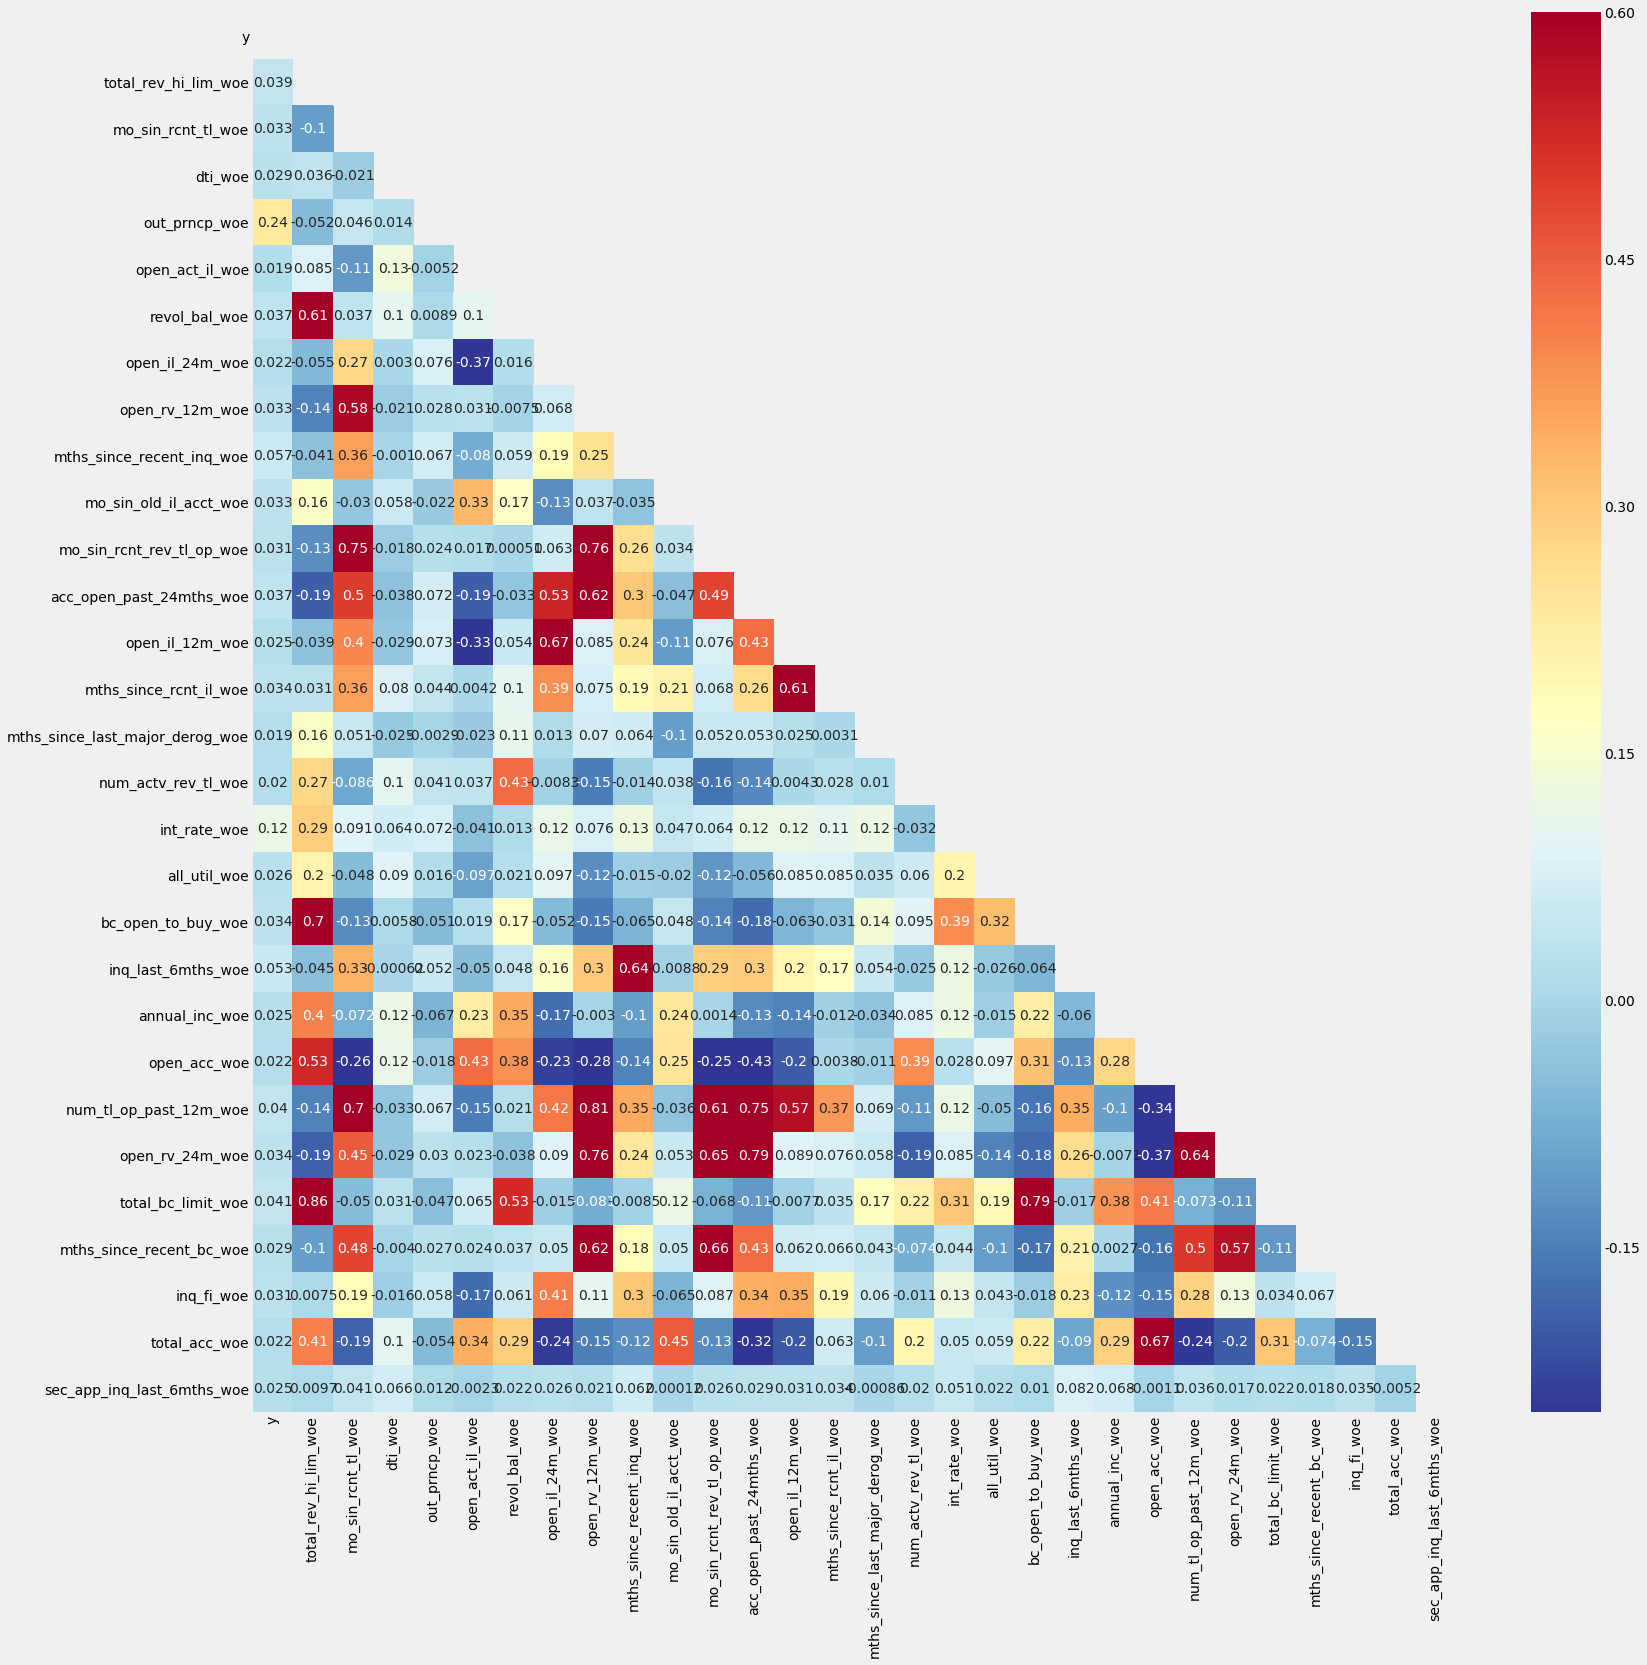

In [41]:
# Heatmap of correlations
plt.figure(figsize = (24, 24))
sns.heatmap(corr_matrix.iloc[:30, :30], mask=mask[:30, :30], cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)

In [42]:
corr_select = corr_matrix.stack().to_frame(name='pearson').reset_index()\
              .query("level_0 != level_1")\
              .query("pearson > 0.8")\
              .sort_values(by='level_0')

In [43]:
del_by_corr = ['deferral_term_woe', 'grade_woe', 'hardship_end_date_woe',
               'hardship_last_payment_amount_woe', 'hardship_length_woe',
               'hardship_loan_status_woe', 'hardship_reason_woe',
               'hardship_start_date_woe', 'hardship_status_woe',
               'settlement_percentage_woe', 'settlement_status_woe',
               'title_woe', 'sub_grade_woe', 'total_bc_limit_woe',
               'verification_status_joint_woe', 'tot_cur_bal_woe',
               'num_tl_op_past_12m_woe']

In [44]:
loan_woe.drop(columns=[col for col in del_by_corr if col in loan_woe.columns], inplace=True)

In [45]:
loan_woe.shape

(490720, 51)

### 包装法：基于模型的特征选择

在使用更多的变量筛选之前，为了更好的比较不同特征组合下模型的表现

我们需要将数据进行训练集-测试集划分，并采用K折交叉验证，综合评估模型的性能

这里因为数据量不大，采用10折验证

训练集-测试集划分

In [46]:
from sklearn.model_selection import train_test_split, KFold

In [47]:
def data_split(df, target, in_sample_size=0.8):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target),
                                                        df[target],
                                                        test_size = 1 - in_sample_size
                                                        )
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_split(loan_woe, 'y')

交叉验证

In [48]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

为了后面评估的方便，我们建立一个统一的模型评估函数

In [58]:
def train_model_sklearn(X, X_test, y, y_test, model_obj, folds, params=None, averaging='usual', verbose=True):
    import time
    start = time.time()

    oof = np.zeros(len(X))

    valid_scores = []
    train_scores = []
    test_prediction = np.zeros(len(X_test))

    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        if type(X) == pd.DataFrame:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if params:
            model = model_obj(**params)
        else:
            model = model_obj()

        model.fit(X_train, y_train)

        train_prediction = model.predict_proba(X_train)[:, 1]
        train_score = roc_auc_score(y_train, train_prediction)
        train_scores.append(train_score)

        valid_prediction = model.predict_proba(X_valid)[:, 1]
        valid_score = roc_auc_score(y_valid, valid_prediction)
        valid_scores.append(valid_score)
        oof[valid_index] = valid_prediction.reshape(-1,)

        if verbose:
            print('Fold {0}: train:{1:.3f}, test:{2:.3f}, diff:{3:.3f}'.format(fold_n, train_score, valid_score, train_score - valid_score))

        test_prediction = model.predict_proba(X_test)[:, 1]

        if averaging == 'usual':
            test_prediction += test_prediction
        elif averaging == 'rank':
            test_prediction += pd.Series(test_prediction).rank().values

    test_prediction /= folds.n_splits
    oof_score = roc_auc_score(y, oof)
    test_score = roc_auc_score(y_test, test_prediction)


    if verbose:
        print('\nAUC mean: {0:.3f}'.format(np.mean(valid_scores)), 
              'std: {0:.3f}'.format(np.std(valid_scores)), 
              'min: {0:.3f}'.format(np.min(valid_scores)), 
              'max: {0:.3f}'.format(np.max(valid_scores)))
        print('Train AUC: {0:.3f}'.format(np.mean(train_scores)))
        print('Validation AUC: {0:.3f}'.format(oof_score))
        print('Test AUC: {0:.3f}'.format(np.mean(test_score)))
        print('it took', time.time() - start, 'seconds.')
    return oof, train_scores, valid_scores, test_score

首先我们确定模型的基线：即未使用任何超参数和变量筛选下的模型评分

In [59]:
# %%
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
oof, train_scores, valid_scores, test_score = train_model_sklearn(X_train,
                                                                  X_test,
                                                                  y_train,
                                                                  y_test,
                                                                  LogisticRegression,
                                                                  folds)

Fold 0.000: train:0.862, test:0.865, diff:-0.003
Fold 1.000: train:0.862, test:0.863, diff:-0.001
Fold 2.000: train:0.861, test:0.867, diff:-0.006
Fold 3.000: train:0.862, test:0.861, diff:0.001
Fold 4.000: train:0.863, test:0.851, diff:0.011
Fold 5.000: train:0.862, test:0.863, diff:-0.001
Fold 6.000: train:0.863, test:0.852, diff:0.011
Fold 7.000: train:0.862, test:0.861, diff:0.001
Fold 8.000: train:0.862, test:0.862, diff:-0.000
Fold 9.000: train:0.861, test:0.868, diff:-0.007

AUC mean: 0.861 std: 0.005 min: 0.851 max: 0.868
Train AUC: 0.862
Validation AUC: 0.861
Test AUC: 0.859
it took 45.66882872581482 seconds.


可以看到模型的train score 和 validation score 以及 test score表现非常接近，说明模型已经非常稳定

平均的OOF AUC为 0.86，作为我们模型评分的baseline

接下来，我们采用尝试使用基于IV值筛选的特征选择方法，探索不同特征组合对模型对影响

In [60]:
# %%
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE, chi2

In [84]:
params_lr = {'solver':'liblinear', 'n_jobs':-1}
scores_dict = {'validation': [], 'test': []}

In [62]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
iv_series = pd.Series({key:val for key,val in iv_list.items() if key in X_train.columns})\
               .sort_values(ascending=False)

In [63]:
N = loan_woe.shape[1]
select_range = range(5, N, 5)

In [64]:
for i in tqdm(select_range):
    SelectKBest_iv = iv_series.head(i).index.tolist()
    X_train_select = X_train[SelectKBest_iv]
    X_test_select = X_test[SelectKBest_iv]
    oof, train_scores, valid_scores, test_score = train_model_sklearn(X_train_select, X_test_select, y_train, y_test,
                                                                      LogisticRegression, folds, params=params_lr, verbose=False)
    scores_dict['validation'].append(np.mean(valid_scores))
    scores_dict['test'].append(np.mean(test_score))

100%|██████████| 10/10 [02:07<00:00, 18.00s/it]


In [65]:
# %%
import plotly.offline as py
py.init_notebook_mode()
import plotly.graph_objs as go
import plotly.tools as tls

In [66]:
data_plot = [go.Scatter(
        x = list(select_range),
        y = scores_dict['validation'],
        name = 'CV validation scores by IV'
    ), go.Scatter(
        x = list(select_range),
        y = scores_dict['test'],
        name = 'CV test scores by IV')
    ]
layout = go.Layout(dict(title = "Top N features by IV",
                  xaxis = dict(title = 'Top N features by IV'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data_plot, layout=layout), filename='basic-line')

观察到使用IV值前20左右的特征，模型AUC达到最大值(0.867)，对应临界IV值是0.03

因此这里我们将IV值小于0.03的特征剔除

In [67]:
select_by_iv2 = iv_series[iv_series >= 0.03].index.tolist()

我们也可以通过RECV等方法，逐步迭代入模变量，选出最好的特征组合

Sklearn内中Recursive feature elimination方法，类似于`逆向回归`，首先将所有的字段纳入模型，再逐一排除

这样的方法通常效率很低，需要遍历较多的模型

In [68]:
from sklearn.feature_selection import RFECV

In [69]:
lr = LogisticRegression(**params_lr)
rfecv = RFECV(estimator=lr, step=1, cv=KFold(5),
              scoring='roc_auc')
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
print("max score of features : {0}".format(rfecv.grid_scores_.max()))

Optimal number of features : 48
max score of features : 0.8613671686291313


In [70]:
data_plot = [go.Scatter(
        x = list(range(1, len(rfecv.grid_scores_) + 1)),
        y = rfecv.grid_scores_,
        name = 'CV validation scores by RECV'
    )
    ]
layout = go.Layout(dict(title = "Number of features selected by RECV",
                  xaxis = dict(title = 'Number of features selected by RECV'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data_plot, layout=layout), filename='basic-line')

通过逐步消除得到的最佳特征组合是37个

对应的模型得分为：0.861，和通过IV值选择的方法相比，效果并不理想

另外，还可以通过训练随机森林，得到特征在树结构内的重要性排名

In [75]:
# %%
from sklearn.ensemble import RandomForestClassifier
params_rf = {'max_depth': 11,
 'max_leaf_nodes': 29,
 'min_samples_leaf': 18,
 'min_samples_split': 20,
 'n_estimators': 390,
 'n_jobs': -1}

In [76]:
rf = RandomForestClassifier(**params_rf)
rf.fit(loan_woe.drop(columns='y'), loan_woe['y'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=29,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=18, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=390, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

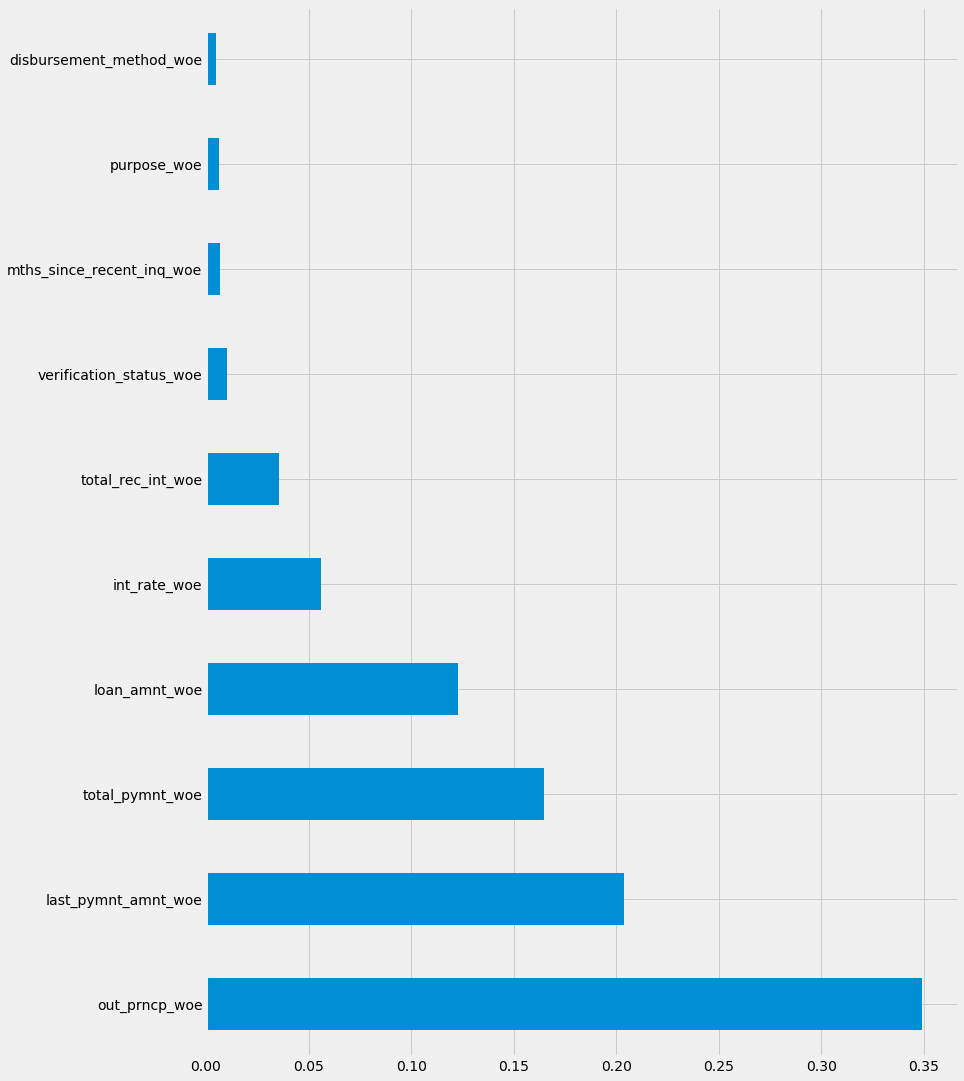

In [77]:
# %%
# Sort feature importances in descending order
plt.figure(figsize=(12,18))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [85]:
scores_dict = {'validation': [], 'test': []}
for i in tqdm(select_range):
    SelectKBest_rf = feat_importances.nlargest(i).index.tolist()
    X_train_select = X_train[SelectKBest_rf]
    X_test_select = X_test[SelectKBest_rf]
    oof, train_scores, valid_scores, test_score = train_model_sklearn(X_train_select, X_test_select, y_train, y_test,
                                                                      LogisticRegression, folds, params=params_lr, verbose=False)
    scores_dict['validation'].append(np.mean(valid_scores))
    scores_dict['test'].append(np.mean(test_score))

100%|██████████| 10/10 [02:22<00:00, 19.07s/it]


In [86]:
data_plot = [go.Scatter(
        x = list(select_range),
        y = scores_dict['validation'],
        name = 'CV validation scores by random forest'
    ), go.Scatter(
        x = list(select_range),
        y = scores_dict['test'],
        name = 'CV test scores by random forest')
    ]
layout = go.Layout(dict(title = "Top N features by random forest",
                  xaxis = dict(title = 'Top N features by random forest'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data_plot, layout=layout), filename='basic-line')

In [87]:
# %%
select_by_rf  = feat_importances.nlargest(25).index.tolist()

总结：
* 通过IV值筛选特征，模型评分在20个左右特征时达到最佳
* 通过递归消除的方法（Recursive feature elimination），模型随着特征数目的增加逐步上升，但最佳得分较低
* 随机森林特征重要性排名，模型得分随着特征数目逐渐上升，并在最大特征数时达到最佳(0.879)

综合考量，我们将IV值前20个字段和随机森林最终重要性得分前30个字段纳入最终的模型

In [94]:
select_by_iv_and_rf = list(set(select_by_iv2) | set(feat_importances.nlargest(25).index.tolist()))

In [95]:
loan_woe = loan_woe[select_by_iv_and_rf + ['y']]

# 构建最终模型

构建最终的评分卡模型主要包括以下几步
* Logisitc Regression 超参数的选择
* 不同特征组合模型效果的比较
* 模型效果的评估

Logisitc Regression 超参数主要为以下几类
* 正则化类型(penalty)：L1正则化/L2正则化
* 正则化惩罚系数(C)的选择
* 对不平衡样本是否调节其样本权重：class_weight：'balanced' or None

在Sklearn中，我们可以采用GridSearchCV(网格搜索)或者RandomizedSearchCV(随机搜索)进行超参数对自动选择

其中GridSearchCV采用贪婪算法，遍历所有超参数，从中选出最佳参数，这种方式比较耗资源和时间，但是能够找到全局最佳超参数

网格搜索适用于三四个（或者更少）的超参数（当超参数的数量增长时，网格搜索的计算复杂度会呈现指数增长）

而RandomizedSearchCV为每个参数定义了一个分布函数并在该空间中随机采样（sampling），这种方式牺牲了一定对准确度，但是显著低提高了搜索的效率

一般来说，如果需要调的参数较多，可以用随机搜索来降低搜索时间，同时又能保证一定的模型准确性。

In [96]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

X_train, X_test, y_train, y_test = data_split(loan_woe, 'y')
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [97]:
lr = LogisticRegression(solver='liblinear', max_iter=10000, n_jobs=-1)

In [98]:
parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l1'],
                  'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0],
                 }

因为希望删除更多的特征，所有penalty强制为`l1正则化`

In [158]:
grid_search = RandomizedSearchCV(lr, param_distributions=parameter_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
best_model = grid_search.fit(X_train, y_train)
print('Best score: {}'.format(best_model.best_score_))
print('Best parameters: {}'.format(best_model.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   56.9s finished


Best score: 0.8777452063726852
Best parameters: {'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.1}


评分卡一般选取10个左右的特征较佳，下面我们尝试使用不同的筛选方式，比较其对模型对影响
* 按照相关系数大小，选取前12个特征
* 按照IV值大小，选取前12个特征
* 根据随机森林特征重要性，选取前12个特征
* 按照经验，人工选取12个特征

In [99]:
# %%
param = {'class_weight' : 'balanced', 'penalty' : 'l1', 'C' : 0.1, 'n_jobs': -1}

In [100]:
lr = LogisticRegression(**param)
lr.fit(X_train, y_train)
coef = pd.DataFrame(lr.coef_, columns=X_train.columns, index=['coef']).T
coef = coef.reindex(coef['coef'].abs().sort_values(ascending=False).index)

In [101]:
select_by_coef_top = coef.head(12).index.tolist()

In [102]:
_, _, valid_scores_a, _ = train_model_sklearn(X_train[select_by_coef_top],
                                            X_test[select_by_coef_top],
                                            y_train,
                                            y_test,
                                            LogisticRegression,
                                            folds,
                                            params=param,
                                            verbose = False)

In [103]:
select_by_iv3 = iv_series.head(12).index.tolist()
_, _, valid_scores_c, _ = train_model_sklearn(X_train[select_by_iv3],
                                            X_test[select_by_iv3],
                                            y_train,
                                            y_test,
                                            LogisticRegression,
                                            folds,
                                            params=param,
                                            verbose = False)

In [104]:
select_by_rf = feat_importances.nlargest(12).index.tolist()
_, _, valid_scores_d, _ = train_model_sklearn(X_train[select_by_rf],
                                            X_test[select_by_rf],
                                            y_train,
                                            y_test,
                                            LogisticRegression,
                                            folds,
                                            params=param,
                                            verbose = False)

In [105]:
select_by_manual = ['out_prncp_woe', 'last_pymnt_amnt_woe',
                 'int_rate_woe', 'total_pymnt_woe', 'addr_state_woe',
                 'verification_status_woe', 'mths_since_recent_inq_woe',
                 'home_ownership_woe', 'disbursement_method_woe', 'total_rec_int_woe',
                 'open_rv_24m_woe', 'mo_sin_old_il_acct_woe']
_, _, valid_scores_b, _ = train_model_sklearn(X_train[select_by_manual],
                                            X_test[select_by_manual],
                                            y_train,
                                            y_test,
                                            LogisticRegression,
                                            folds,
                                            params=param,
                                            verbose = False)

Text(0.5,0,'group')

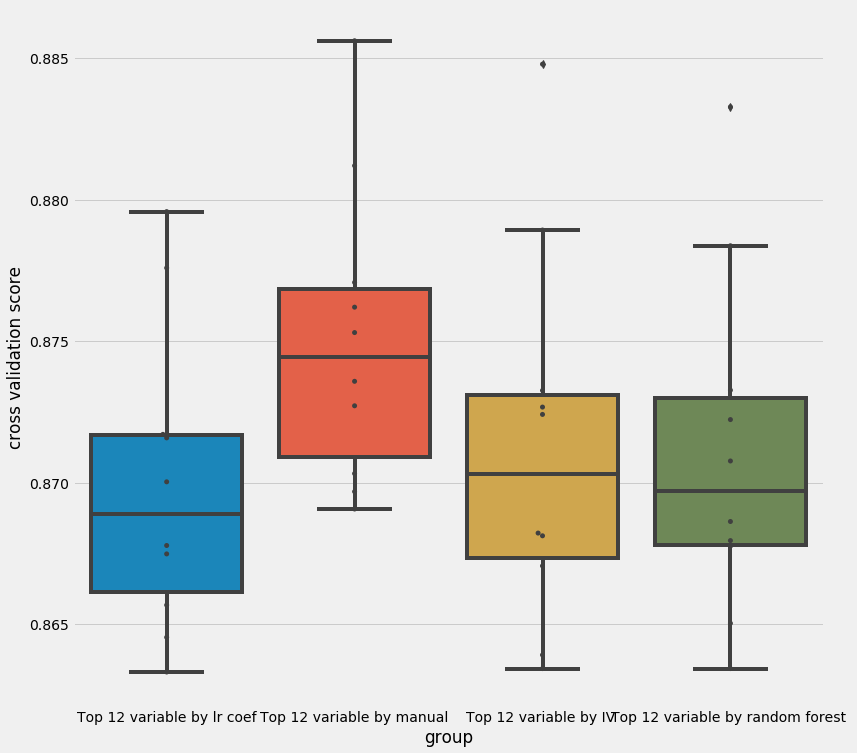

In [106]:
plt.figure(figsize = (12, 12))
score = pd.DataFrame({"Top 12 variable by lr coef":valid_scores_a,
                  "Top 12 variable by manual":valid_scores_b,
                  "Top 12 variable by IV ": valid_scores_c,
                  "Top 12 variable by random forest ": valid_scores_d,
                }).stack().to_frame(name='score').reset_index()
ax = sns.boxplot(x="level_1", y="score", data=score)
ax = sns.swarmplot(x="level_1", y="score", data=score, color=".25")
ax.set_ylabel('cross validation score')
ax.set_xlabel('group')

可以看到根据经验筛选出的特征表现最好~

而直接根据系数大小筛选出来的特征不仅从稳定性还是效果来说，都比较差
模型间的差异不到1%

---

评分卡要求备选的逻辑回归模型达到三个基本要求:
* 精确性，达到可接受水平。
* 稳健性，要求能够适用于更广范围的数据集。
* 有意义，即业务变量及其预测值是可解释的。例如，信用卡的额度利用率越高，违约率相应也越高。

一个好的模型一般应具有以下特征：
* 在进行数据描述时变量应该有意义。通常，某些变在特定客群的不同风险模型中重复出现。例如，信用卡行为评分卡模型中，授信使用率经常出现；申请评分卡模型中收入水平、职业和历史信贷产品拥有情况比人口统计变量重要。
* 变量的预测力或贡献度，应该在模型的变量之间分布。
* 模型中不应该包含太多变量。通常，包含的变量不超过9~20个(最优10~12个)。变量太多可能导致过拟合，变量太少往往区分度不够。
* 最终模型的变量应该能够确保包含稳健一致的数据，并在后续实施阶段能够准确获取。

我们最终决定使用根据经验筛选出的12个特征作为最后入模字段

In [107]:
# %%
param = {'class_weight' : 'balanced', 'penalty' : 'l1', 'C' : 0.15, 'n_jobs': -1}
lr = LogisticRegression(**param)
lr.fit(X_train[select_by_manual], y_train)
train_pred = lr.predict_proba(X_train[select_by_manual])[:,1]
test_pred = lr.predict_proba(X_test[select_by_manual])[:,1]

最终模型系数

In [108]:
pd.DataFrame(lr.coef_, columns=select_by_manual, index=['coef']).T

coef
out_prncp_woe              1.539149
last_pymnt_amnt_woe        1.343974
int_rate_woe               0.797016
total_pymnt_woe            1.082229
addr_state_woe             0.895682
verification_status_woe    0.553293
mths_since_recent_inq_woe  0.666479
home_ownership_woe         0.623323
disbursement_method_woe    0.451732
total_rec_int_woe         -0.751407
open_rv_24m_woe            0.658599
mo_sin_old_il_acct_woe     0.697556

### 模型的有效性
模型的有效性主要用以下统计量度量
* ROC-AUC曲线
* KS(柯尔莫哥洛夫-斯米尔诺夫kolmogorov-smirnow)曲线
* 提升度曲线

ROC 曲线

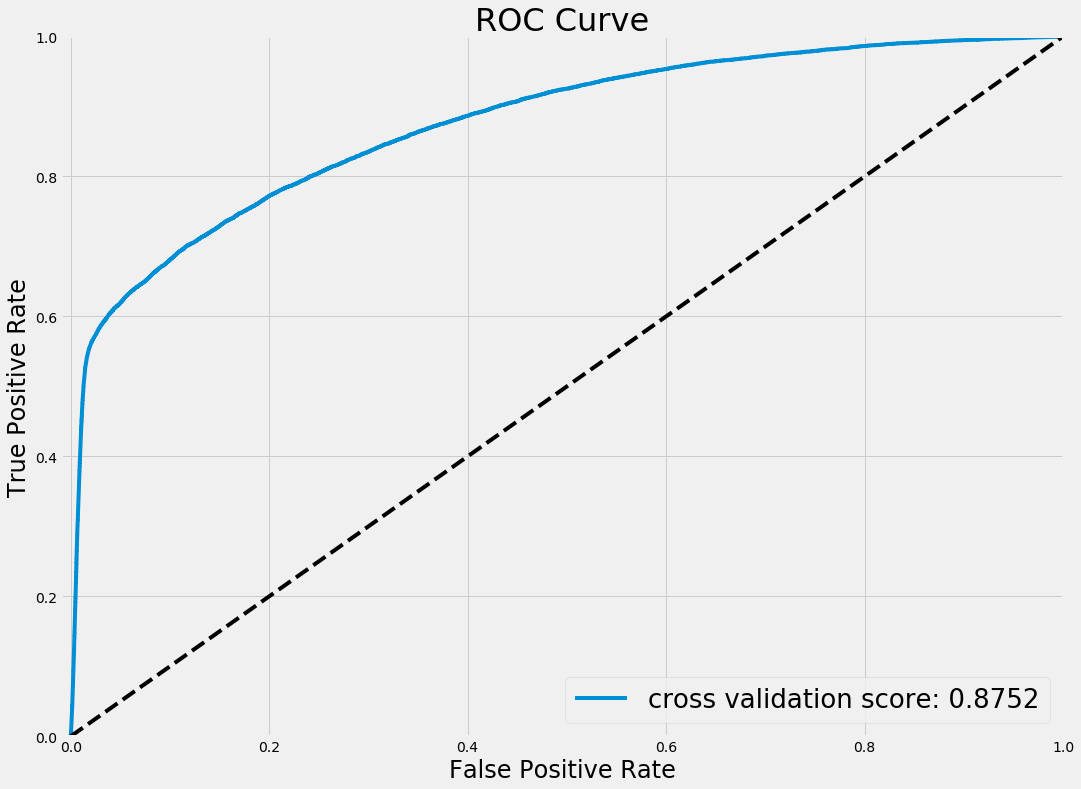

In [109]:
# %%
from sklearn.metrics import roc_curve
fpr, tpr, thresold = roc_curve(y_train, train_pred)
plt.style.use('fivethirtyeight')
def graph_roc_curve(fpr, tpr, y, predict):
    plt.figure(figsize=(16,12))
    plt.title('ROC Curve', fontsize=32)
    plt.plot(fpr, tpr, label='cross validation score: {:.4f}'.format(roc_auc_score(y, predict)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=24)
    plt.ylabel('True Positive Rate', fontsize=24)
    plt.legend(loc='lower right', prop={'size': 26})
graph_roc_curve(fpr, tpr, y_train, train_pred)

提升度统计

In [110]:
# %%
def graph_left_curve(y_actual, y_predict):
    df = pd.DataFrame({0:1- y_predict, 1:y_predict}).values
    from matplotlib.ticker import FuncFormatter
    import scikitplot as skplt
    ax = skplt.metrics.plot_lift_curve(y_actual, df,
                                      figsize = (16,12),
                                      title_fontsize = 36,
                                      text_fontsize = 24)
    ax.legend(['Y = 0', 'Y = 1', 'Baseline'], loc = 'upper right', fontsize=36)
    ax.xaxis.set_ticks(np.arange(0, 11, 1.0)/10)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.xaxis.label.set_size(32)
    ax.yaxis.label.set_size(32)

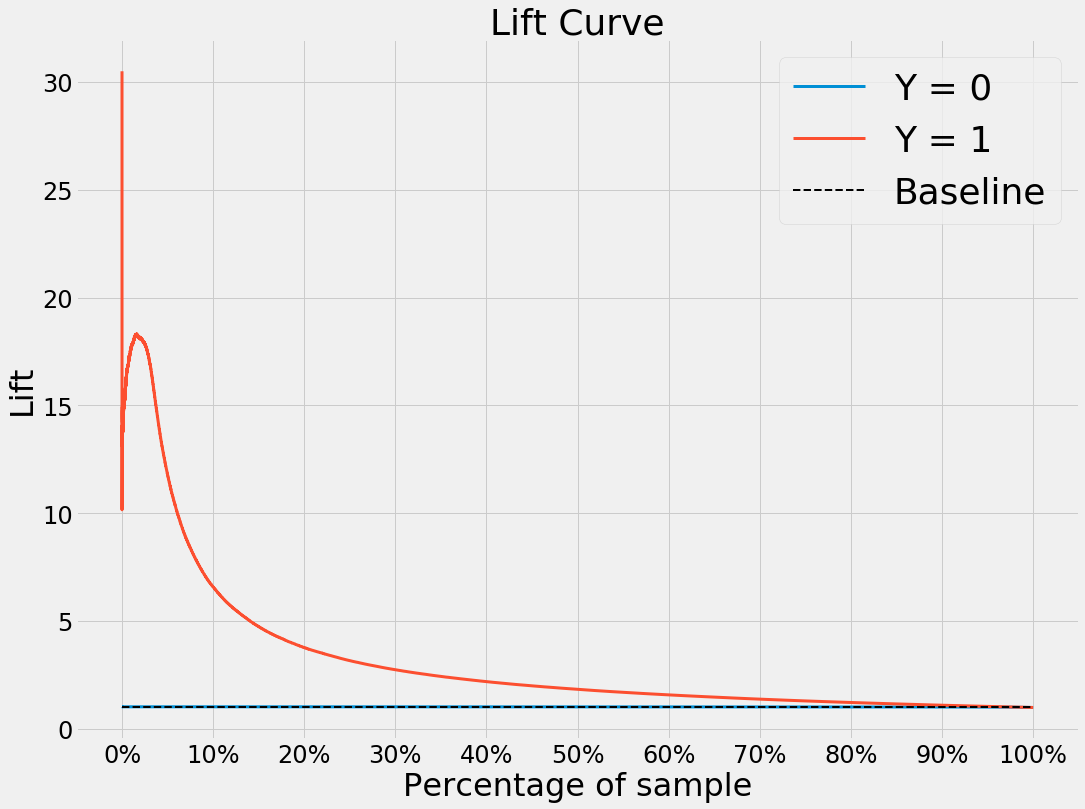

In [111]:
graph_left_curve(y_train, train_pred)

K-S curve

<Figure size 864x648 with 0 Axes>

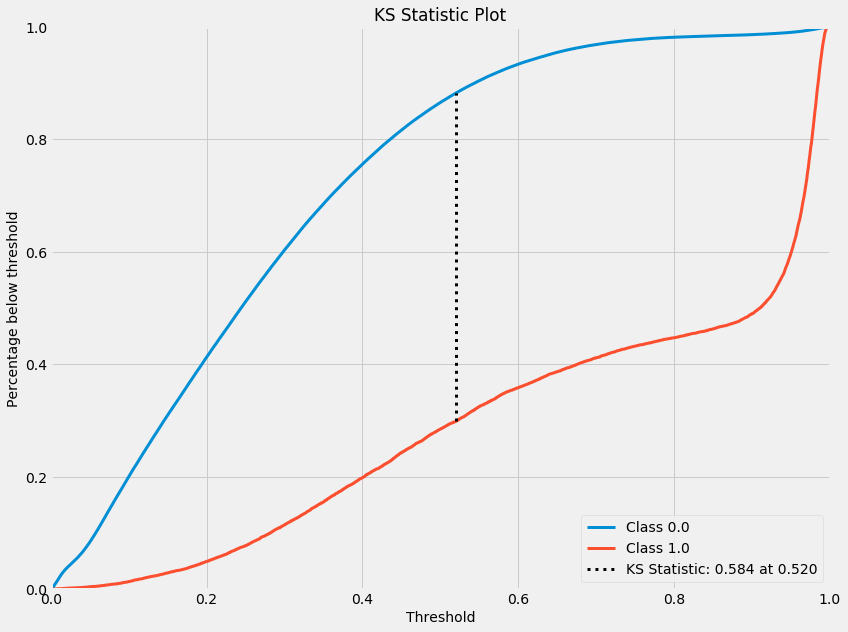

In [112]:
import scikitplot as skplt
plt.figure(figsize=(12,9))
pred = lr.predict_proba(X_train[select_by_manual])
fig, ax = plt.subplots(figsize=(12,9), tight_layout=True)
skplt.metrics.plot_ks_statistic(y_train, pred, ax=ax)
plt.show()

# 评分刻度与实施

标准评分卡采用的格式是评分卡的每一个变量都遵循一系列`IF-THEN`法则。数据记录中每一个变量的值都适用此法则的结果决定了该特定变量所分配的分值。总分就是评分卡中所有变量的贡献的和。下面是一个示例：
![alt text](http://static.zybuluo.com/77qingliu/8g50h56260yzv6b5wm8mgje1/image.png)

标准评分卡的简单形式具有如下几方面的优势。

* 由于各变量得分相加得到最终得分，每个变量对最终得分的影响都清楚明了。
* 每个评分卡变量分别取最高和最低贡献，可以很容易地计算出可能的最高得分和最低得分。
* 分值分配是根据比率的概念，随着分值的降低，违约的比率将提高一倍。例如，一个评分卡可以设计为评分降低20分，违约的比率将提高一倍。
* 因为每一个得分都对应特定的违约比率，所以用评分系统可以很容易的设定信贷政策。因此，信贷提供者可以很容易地控制预期的违约账户比例及其对应的成本。

## 评分卡刻度
将估计的违约概率表示为p，则估计的正常概率为1-p。可以得到
$$
Odds = \frac{p}{1-p}
$$

评分卡设定的刻度值可以通过将分值表示为比率对数的线性表达式来定义。如下：
$$
Score = A-B\log(Odds)
$$

其中，A和B是常数。方程中的符号可以使得违约概率越低，得分越高。
logistic回归模型计算比率如下：
$$
log(Odds) = \beta_0+\beta_1x_1+...+\beta_px_p
$$

常数A和B的值可以通过将两个已知或假设的分值代入公式$Score = A-B\log(Odds)$得到。通常，需要两个假设：

* 在某个特定的比率设定特定的预期分值。
* 指定比率翻番的分数（PDO）

首先，设定比率为$\theta_0$的特定点的分值为$P_0$。然后，比率为$2\theta_0$的点的分值为$P_0 + PDO$，代入上述得分公式可以得到如下两个等式：

$$\begin{aligned}
P_0 &= A-B\log(\theta_0)\\
P_0 + PDO &= A-B\log(2\theta_0)
\end{aligned}
$$

解上述两个方程中的常数A和B，可以得到：
$$\begin{aligned}
B &= \frac{PDO}{log(2)}\\
A &= P_0 + B\log(\theta_0)
\end{aligned}
$$
例如，假设想要设定评分卡刻度使得比率为{1:60}（违约比正常）时的分值为600分，PDO=20。然后，给定B=28.85，A=481.86。则可以计算分值为：
$$
Score = 481.89 - 28.85\log(Odds)
$$
通常A被称为补偿，B被称为刻度。
评分卡刻度A和B确定以后，就可以用公式计算比率和违约概率，以及对应的分值。
![alt text](http://static.zybuluo.com/77qingliu/5mls231897xi4ajfldww4p3r/image.png)


## 分值分配
合并公式，可以将评分卡的分值写成一下形式：
$$
Score = A-B\{\beta_0+\beta_1x_1+...+\beta_px_p\}
$$
由于所有变量都进行了WOE转换，将转换后的变量代入上式，得到：

$$
\begin{aligned}
Score =&(A-B\beta_0)\\
&-(B\beta_1w_{11})\delta_{11}- (B\beta_1w_{12})\delta_{12}-\cdot\cdot\cdot \\&-(B\beta_2w_{21})\delta_{21}-(B\beta_2w_{22})\delta_{22}-\cdot\cdot\cdot\\
&-(B\beta_3w_{31})\delta_{31}-(B\beta_3w_{32})\delta_{32}-\cdot\cdot\cdot\\
&\cdot\cdot\cdot
\end{aligned}
$$
上式便是最终评分卡的公式。整理成下表：
![alt text](http://static.zybuluo.com/77qingliu/7b0axllkmcvrs1sx63e7kks4/image.png)



### Python实施
结合之前的分段信息，可以直接使用Scorecardpy中已有的实现

In [113]:
from scorecardpy import scorecard
score_card = scorecard(all_combine_bin, lr, select_by_manual)
df_bin = pd.concat(all_combine_bin)\
            .reset_index(drop=True)\
            .set_index(['variable', 'bin'])
df_score_card = pd.concat(score_card).reset_index()\
                  .set_index(['variable', 'bin'])

In [114]:
df_score_final = df_bin.merge(df_score_card, left_index=True, right_index=True, validate='1:1')\
                       .sort_index(level=[0,1])\
                       .drop(columns=['breaks', 'is_special_values', 'level_0', 'level_1'])

In [115]:
df_score_final.head()

count  count_distr  \
variable   bin                                                              
addr_state CT%,%MT%,%OH%,%DC                           26130     0.053248   
           ID%,%AK%,%WA%,%OR%,%RI%,%SC%,%NH%,%CO%,%KY  45815     0.093363   
           ME%,%WV%,%VT%,%WY%,%KS%,%ND%,%IL            30976     0.063124   
           MI%,%MD%,%SD%,%HI%,%CA                      94027     0.191610   
           MN%,%TX%,%LA%,%AZ%,%PA%,%MA%,%NM%,%AR       98989     0.201722   

                                                        good   bad   badprob  \
variable   bin                                                                 
addr_state CT%,%MT%,%OH%,%DC                           25524   606  0.023192   
           ID%,%AK%,%WA%,%OR%,%RI%,%SC%,%NH%,%CO%,%KY  44637  1178  0.025712   
           ME%,%WV%,%VT%,%WY%,%KS%,%ND%,%IL            30332   644  0.020790   
           MI%,%MD%,%SD%,%HI%,%CA                      90633  3394  0.036096   
           MN%,%TX%,%LA%,%AZ%,%PA%,%MA%,%NM%,%AR       95722  3267  0.033004   

                                                            woe    bin_iv  \
variable   bin                                                              
addr_state CT%,%MT%,%OH%,%DC                          -0.356478  0.005748   
           ID%,%AK%,%WA%,%OR%,%RI%,%SC%,%NH%,%CO%,%KY -0.250729  0.005229   
           ME%,%WV%,%VT%,%WY%,%KS%,%ND%,%IL           -0.468243  0.011189   
           MI%,%MD%,%SD%,%HI%,%CA                      0.099207  0.001976   
           MN%,%TX%,%LA%,%AZ%,%PA%,%MA%,%NM%,%AR       0.006440  0.000008   

                                                       total_iv  points  
variable   bin                                                           
addr_state CT%,%MT%,%OH%,%DC                           0.034653    23.0  
           ID%,%AK%,%WA%,%OR%,%RI%,%SC%,%NH%,%CO%,%KY  0.034653    16.0  
           ME%,%WV%,%VT%,%WY%,%KS%,%ND%,%IL            0.034653    30.0  
           MI%,%MD%,%SD%,%HI%,%CA                      0.034653    -6.0  
           MN%,%TX%,%LA%,%AZ%,%PA%,%MA%,%NM%,%AR       0.034653    -0.0

# 评分卡评估与监控

In [122]:
from scorecardpy import scorecard_ply
import re
select_by_manual_ori = [re.sub('_woe$', '', col) for col in select_by_manual]
df_score_test = loan.loc[X_test.index, select_by_manual_ori + ['y']]

In [123]:
score_test = scorecard_ply(df_score_test.sort_index(), score_card)

In [124]:
score_test['y'] = y_test
score_test['y_pred'] = test_pred

In [125]:
score_test.groupby('y')['score'].describe()

KeyError: 'Column not found: score'

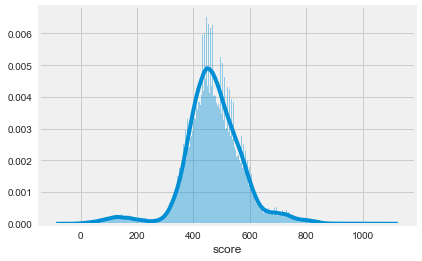

In [487]:
sns.distplot(score_test['score'], bins=500)

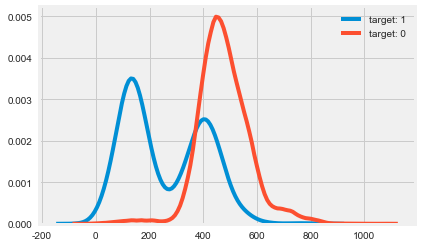

In [488]:
sns.kdeplot(score_test[df_score_test['y'] == 1]['score'], label="target: 1")
sns.kdeplot(score_test[df_score_test['y'] == 0]['score'], label="target: 0")

模型的区分度非常明显